Code to create and run linear models for unfiltered data (all wind speeds)

In [477]:
#Import required modules
import pandas as pd, xarray as xr, numpy as np, matplotlib.pyplot as plt, sklearn as sk, scipy

In [478]:
#Load in feature and label data
features = pd.read_csv('all_feature_data.csv')
labels = pd.read_csv('all_label_data.csv')
features = features.drop(columns = ['Unnamed: 0'])
labels = labels.drop(columns = ['Unnamed: 0'])

In [479]:
#Remove data points with more than half of features missing
dropidxs = []
for i in range(features.shape[0]):
  if pd.isnull(features).sum(axis = 1)[i] > 0.5*features.shape[1]:
    dropidxs.append(i)
print('Dropping ' + str(len(dropidxs)) + ' data points due to missing data')

features = features.drop(index = dropidxs).reset_index(drop=True)
labels = labels.drop(index = dropidxs).reset_index(drop=True)

Dropping 75 data points due to missing data


Train/Test/Validate Split

In [480]:
from numpy import random
#Set random seed for reproducible results
np.random.seed(1)

In [481]:
#Randomly select indices for training and testing data

other_indices = []
test_indices = []
validate_indices = []
train_indices = []

#Get train indices randomly (60% of dataset)
while len(train_indices) < int(np.round(features.shape[0] * 0.6)):
  i = np.random.randint(0, features.shape[0])
  if i not in train_indices:
    train_indices.append(i)

#Get indices not in train_indices
for i in range(features.shape[0]):
  if i not in train_indices:
    other_indices.append(i)

#Split other_indices into validate indices and test indices evenly
while len(validate_indices) < int(np.round(len(other_indices) * 0.5)):
  i = np.random.randint(0, len(other_indices))
  if other_indices[i] not in validate_indices:
    validate_indices.append(other_indices[i])

for i in range(len(other_indices)):
  if other_indices[i] not in validate_indices:
    test_indices.append(other_indices[i])

#Convert indices to numpy arrays
train_indices = np.array(train_indices)
validate_indices = np.array(validate_indices)
test_indices = np.array(test_indices)

#Make array containing train and validate indices (for use in cross-validation)
train_and_validate_indices = []
train_and_validate_indices.extend(train_indices)
train_and_validate_indices.extend(validate_indices)

Standardize Data

In [482]:
#Split into training, validation, and testing features and labels
training_features_array = features.iloc[train_indices].values
training_labels_array = labels.iloc[train_indices, 1:].values
validate_features_array = features.iloc[validate_indices].values
validate_labels_array = labels.iloc[validate_indices, 1:].values
testing_features_array = features.iloc[test_indices].values
testing_labels_array = labels.iloc[test_indices, 1:].values

#Standardize features
from sklearn.preprocessing import StandardScaler
all_features_array_scaled = StandardScaler().fit(np.array(features)).transform(np.array(features))

#Get standardized training, validation, and testing features
training_features_array_scaled = all_features_array_scaled[train_indices, :]
validate_features_array_scaled = all_features_array_scaled[validate_indices, :]
testing_features_array_scaled = all_features_array_scaled[test_indices, :]

Highest Correlation-Coefficient Single Predictor [ws8001] OLS Model

In [483]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Get cross-validatino score from 5-fold CV using train and validate indices together
one_pred_OLS_cv = cross_val_score(LinearRegression(), features.iloc[train_and_validate_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))

#Train model on training set and record validation set R^2
one_pred_OLS_trainonly = LinearRegression().fit(features.iloc[train_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
one_pred_OLS_validscore = one_pred_OLS_trainonly.score(features.iloc[validate_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

#Print cross-validation and validation-set R^2 values
print(("Cross-validation mean R squared: " + str(one_pred_OLS_cv.mean())))
print(("Cross-validation stdev R squared: " + str(one_pred_OLS_cv.std())))
print(("Validation set R squared is: " + str(one_pred_OLS_validscore)))

Cross-validation mean R squared: 0.7320490066874752
Cross-validation stdev R squared: 0.018997561477641395
Validation set R squared is: 0.7156653020032606


Text(0.5, 1.0, 'Single-predictor OLS Predicted vs. Actual Wind Speed')

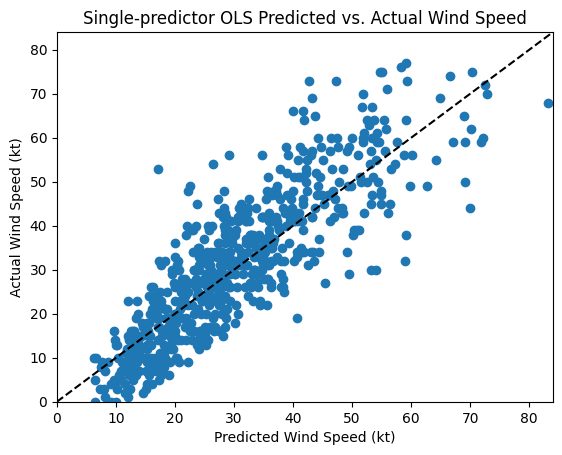

In [484]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Plot model predictions vs actual for validation set
one_pred_OLS = LinearRegression().fit(features.iloc[train_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
one_pred_OLS_predictions = one_pred_OLS.predict(features.iloc[validate_indices]['ws8001'].values.reshape(-1, 1)) #Get model predictions on validation set

plt.scatter(one_pred_OLS_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([0, 84])
plt.xlim([0, 84])

#label axes
plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('Single-predictor OLS Predicted vs. Actual Wind Speed')

All-Predictors Linear Model for Non-Standardized Data

In [485]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


#Get 5-fold cross-validation scores for models trained on subset of train and validate features together
multi_pred_unscaled_OLS_cv = cross_val_score(LinearRegression(), features.iloc[train_and_validate_indices].values, labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))

#Train model on training set only and get validation R^2
multi_pred_unscaled_OLS_trainonly = LinearRegression().fit(features.iloc[train_indices].values, labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_unscaled_OLS_validscore = multi_pred_unscaled_OLS_trainonly.score(features.iloc[validate_indices].values, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

#Print CV and validation set scores
print(("Cross-validation mean R squared: " + str(multi_pred_unscaled_OLS_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_unscaled_OLS_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_unscaled_OLS_validscore)))

Cross-validation mean R squared: 0.8400890649274327
Cross-validation stdev R squared: 0.0077167790059836415
Validation set R squared is: 0.8405126713777658


Text(0.5, 1.0, 'All-predictor OLS Predicted vs. Actual Wind Speed \n Non-Standardized Features')

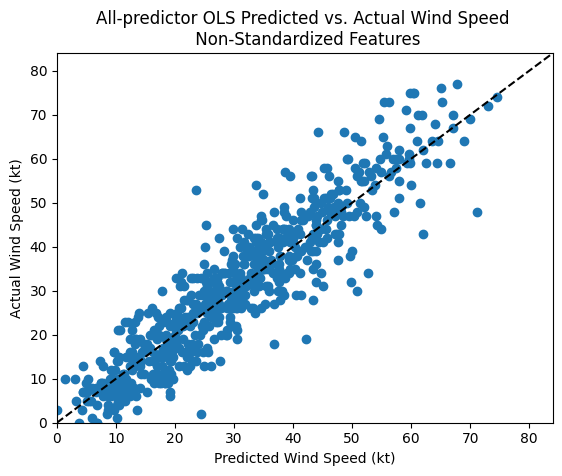

In [486]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Fit linear regression model using training set only, get predictions on validation set
multi_pred_unscaled_OLS = LinearRegression().fit(features.iloc[train_indices].values, labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_unscaled_OLS_predictions = multi_pred_unscaled_OLS.predict(features.iloc[validate_indices].values)

#Make scatterplot of predictions vs. true values
plt.scatter(multi_pred_unscaled_OLS_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([0, 84])
plt.xlim([0, 84])

#Label axes
plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('All-predictor OLS Predicted vs. Actual Wind Speed \n Non-Standardized Features')

All-Predictors Linear Model for Standardized Data

In [487]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


#Get 5-fold CV scores from model fit to training and validation sets
multi_pred_OLS_standardized_cv = cross_val_score(LinearRegression(), all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))

#Fit model using training set only, get R^2 for validation set
multi_pred_OLS_standardized_trainonly = LinearRegression().fit(all_features_array_scaled[train_indices, :], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_OLS_standardized_validscore = multi_pred_OLS_standardized_trainonly.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

#Print R^2 results from CV and validation set
print(("Cross-validation mean R squared: " + str(multi_pred_OLS_standardized_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_OLS_standardized_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_OLS_standardized_validscore)))

Cross-validation mean R squared: 0.8401604631964655
Cross-validation stdev R squared: 0.00769088199291585
Validation set R squared is: 0.8407392741034052


In [488]:
#Make a slight perturbation (called a) to features
a = np.zeros(len(all_features_array_scaled[test_indices, :][0]))
a[5] = 1

In [489]:
#Predict wind speed without a perturbation for the first test data point
multi_pred_OLS_standardized.predict(all_features_array_scaled[test_indices[0], :].reshape(1, -1))

array([[33.43149059]])

In [490]:
#Predict wind speed with perturbation to the first test data point [note significant difference]
multi_pred_OLS_standardized.predict((all_features_array_scaled[test_indices[0], :] + a).reshape(1, -1))

array([[-1.41770832e+12]])

Text(0.5, 1.0, 'All-predictor OLS Predicted vs. Actual Wind Speed \n Standardized Features')

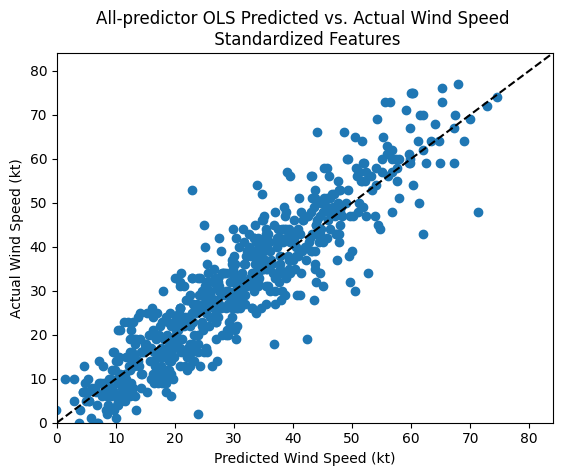

In [491]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Fit linear regression model to standardized data using only training data points, get model predictions
multi_pred_OLS_standardized = LinearRegression().fit(all_features_array_scaled[train_indices], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_OLS_standardized_predictions = multi_pred_OLS_standardized.predict(all_features_array_scaled[validate_indices])

#Make scatterplot of predicted vs. actual wind speeds
plt.scatter(multi_pred_OLS_standardized_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([0, 84])
plt.xlim([0, 84])

#Label axes
plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('All-predictor OLS Predicted vs. Actual Wind Speed \n Standardized Features')

Text(0.5, 1.0, 'All-Feature OLS with Standardized Data: \n Feature Coefficients')

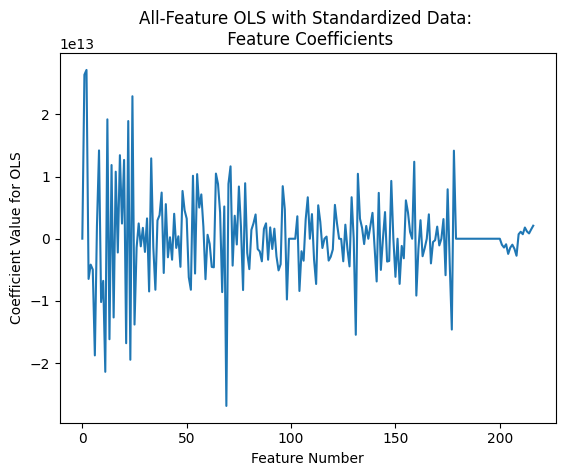

In [492]:
#Plot feature coefficients of model
plt.plot(multi_pred_OLS_standardized.coef_[0])
plt.xlabel('Feature Number')
plt.ylabel('Coefficient Value for OLS')
plt.title('All-Feature OLS with Standardized Data: \n Feature Coefficients')

In [493]:
#Perform bootstrapping to estimate prediction variance
bootstrap_pred_scores = []
bootstrap_w = []
#Take 50 bootstrap samples
for iter in range(50):
  bootstrap_indices = []
  #In each sample, pick 50 percent of training data points
  for i in range(int(round(len(train_indices) / 2))):
    bootstrap_indices.append(train_indices[np.random.randint(0, len(train_indices))])
  bootstrap_indices = np.array(bootstrap_indices)
  #Fit model to bootstrap sample and get R^2 on validation set
  multi_pred_OLS_standardized = LinearRegression().fit(all_features_array_scaled[bootstrap_indices, :], labels.iloc[bootstrap_indices]['sknt'].values.reshape(-1, 1))
  score = multi_pred_OLS_standardized.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
  #Store model coefficients
  w = multi_pred_OLS_standardized.coef_[0]
  bootstrap_pred_scores.append(score)
  bootstrap_w.append(w)
  
#Print mean and stdev of bootstrap R^2 results
print('Mean of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).mean()))
print('StDev of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).std()))

Mean of bootstrapped R squared is: 0.8162492611617419
StDev of bootstrapped R squared is: 0.006494235900798501


In [494]:
#Print standard deviation of bootstrap feature coefficients
np.array(bootstrap_w).std(axis = 0)

array([6.08634503e+09, 1.82361308e+13, 1.72240313e+13, 7.14122022e+12,
       1.49414749e+13, 1.39140996e+13, 2.67181211e+13, 1.17672022e+13,
       1.91902935e+13, 1.50111108e+13, 1.44779948e+13, 2.62810034e+13,
       2.79106560e+13, 1.02427896e+13, 8.89276617e+12, 9.61337659e+12,
       6.50871466e+12, 9.76637591e+12, 8.29208142e+12, 1.39611847e+13,
       1.14256423e+13, 9.68004944e+12, 1.77247693e+13, 1.07582093e+13,
       1.57205094e+13, 1.35916940e+13, 6.02464599e+12, 7.53185343e+12,
       1.17415457e+13, 9.07367678e+12, 1.04054481e+13, 5.65746555e+12,
       1.05764230e+13, 9.65556869e+12, 5.08882224e+12, 7.05787971e+12,
       4.59562204e+12, 8.22966584e+12, 8.16318590e+12, 8.96274675e+12,
       1.08442675e+13, 6.66739245e+12, 8.38384507e+12, 8.27637854e+12,
       6.34335188e+12, 8.18511978e+12, 9.86267689e+12, 1.54570593e+13,
       1.54923109e+13, 7.95377553e+12, 7.02297275e+12, 1.06078584e+13,
       8.97980540e+12, 5.43340602e+12, 5.36276452e+12, 5.94520990e+12,
      

All-Predictors Ridge Regression Linear Model for Standardized Data, L2 Regularization

Cross-validation mean R squared: 0.840483166365971
Cross-validation stdev R squared: 0.007094113125909896
Validation set R squared is: 0.8391315307098156
Test set R squared is: 0.8495721691765755


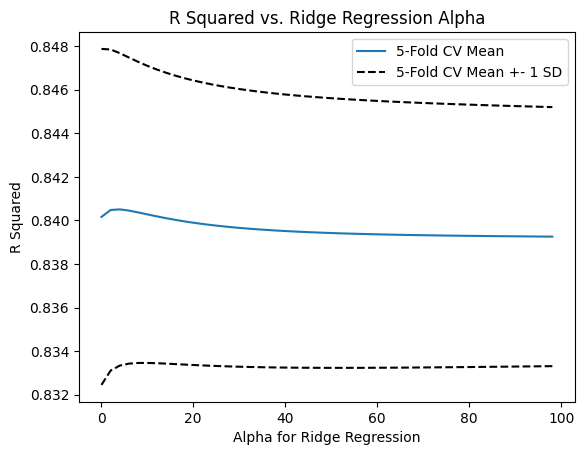

In [495]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

#Store means and stds for cross-validation
cv_means = []
cv_stds = []

#Iterate through values of alpha (ridge_coeff)
for ridge_coeff in np.arange(0.05, 100, 2):
  #Get cross-validation scores from 5-fold cross validation
  multi_pred_ridge_standardized_cv = cross_val_score(Ridge(ridge_coeff), all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  cv_means.append(multi_pred_ridge_standardized_cv.mean())
  cv_stds.append(multi_pred_ridge_standardized_cv.std())

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

#Plot cross-validation scores and standard deviation
plt.plot(np.arange(0.05, 100, 2), cv_means, label = '5-Fold CV Mean')
plt.plot(np.arange(0.05, 100, 2), cv_means + cv_stds, '--k', label = "5-Fold CV Mean +- 1 SD")
plt.plot(np.arange(0.05, 100, 2), cv_means - cv_stds, '--k')
plt.xlabel('Alpha for Ridge Regression')
plt.ylabel('R Squared')
plt.title('R Squared vs. Ridge Regression Alpha')
plt.legend()

#Get R^2 mean and stdev from 5-fold CV with alpha = 5
multi_pred_ridge_standardized_cv = cross_val_score(Ridge(5), all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))

#Fit ridge regression to training dataset only and get R^2 for validation and test sets
multi_pred_ridge_standardized_trainonly = Ridge(5).fit(all_features_array_scaled[train_indices, :], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_validscore = multi_pred_ridge_standardized_trainonly.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_testscore = multi_pred_ridge_standardized_trainonly.score(all_features_array_scaled[test_indices, :], labels.iloc[test_indices]['sknt'].values.reshape(-1, 1))

#Print R^2 results
print(("Cross-validation mean R squared: " + str(multi_pred_ridge_standardized_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_ridge_standardized_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_ridge_standardized_validscore)))
print(("Test set R squared is: " + str(multi_pred_ridge_standardized_testscore)))

In [496]:
#Perform bootstrapping to estimate prediction variance
bootstrap_pred_scores = []
bootstrap_w = []
#Take 50 bootstrap samples
for iter in range(50):
  bootstrap_indices = []
  #Each sample has half the number of data points as training set
  for i in range(int(round(len(train_indices) / 2))):
    bootstrap_indices.append(train_indices[np.random.randint(0, len(train_indices))])
  bootstrap_indices = np.array(bootstrap_indices)
  #Fit ridge regression with alpha = 5, keep track of R^2 and feature coefficients (entries of w)
  multi_pred_ridge_standardized = Ridge(5).fit(all_features_array_scaled[bootstrap_indices, :], labels.iloc[bootstrap_indices]['sknt'].values.reshape(-1, 1))
  score = multi_pred_ridge_standardized.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
  bootstrap_pred_scores.append(score)
  bootstrap_w.append(multi_pred_ridge_standardized.coef_[0])

#Print bootstrap mean R^2 and stdev R^2
print('Mean of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).mean()))
print('StDev of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).std()))

Mean of bootstrapped R squared is: 0.8173326319991066
StDev of bootstrapped R squared is: 0.007937514193963583


In [497]:
#Print stdev. of feature coefficients (entries of w) across the 50 bootstrap models
np.array(bootstrap_w).std(axis = 0)

array([0.34303721, 0.23171648, 0.24116435, 0.16582245, 0.25811421,
       0.47015176, 0.22341591, 0.42401316, 0.25539802, 0.29503312,
       0.15944055, 0.17470745, 0.12533142, 0.18991442, 0.31844698,
       0.1912239 , 0.26874954, 0.2013433 , 0.3375484 , 0.26374279,
       0.28594652, 0.20110776, 0.27385288, 0.48247781, 0.25825188,
       0.48507827, 0.27566477, 0.23623749, 0.15116327, 0.15109986,
       0.14715808, 0.14324142, 0.23454227, 0.12696777, 0.21305226,
       0.14734962, 0.39767809, 0.35723624, 0.26807375, 0.22841081,
       0.28355789, 0.52682167, 0.30244139, 0.42300336, 0.26823432,
       0.23895639, 0.1505661 , 0.16091041, 0.1192189 , 0.18564988,
       0.26107791, 0.16901728, 0.19798164, 0.12690909, 0.18675564,
       0.16209177, 0.12507606, 0.12176766, 0.19423171, 0.20943309,
       0.12645973, 0.19472391, 0.14009747, 0.243931  , 0.24095513,
       0.16990754, 0.17738861, 0.280338  , 0.23861813, 0.14952095,
       0.22776594, 0.15865313, 0.30042263, 0.14330977, 0.17632

Text(0.5, 1.0, 'All-predictor Ridge Regression Predicted vs. Actual Wind Speed \n Standardized Features')

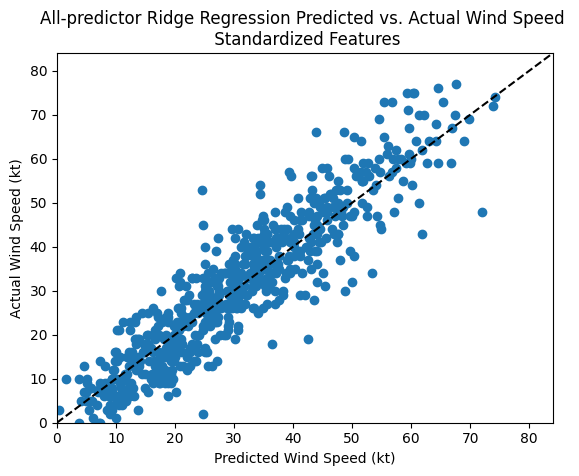

In [498]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

#Fit ridge regression with alpha = 5 to training data and make predictions on validation set
multi_pred_ridge_standardized = Ridge(5).fit(all_features_array_scaled[train_indices], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_predictions = multi_pred_ridge_standardized.predict(all_features_array_scaled[validate_indices])

#Plot predictions vs. actual wind speed
plt.scatter(multi_pred_ridge_standardized_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([0, 84])
plt.xlim([0, 84])


plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('All-predictor Ridge Regression Predicted vs. Actual Wind Speed \n Standardized Features')

Text(0.5, 1.0, 'All-Feature Ridge Regression (alpha = 5) with Standardized Data: \n Feature Coefficients')

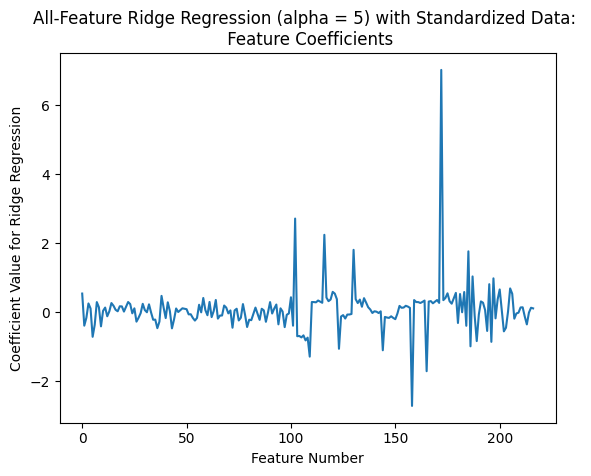

In [499]:
#Plot feature coefficients
plt.plot(multi_pred_ridge_standardized.coef_[0])
plt.xlabel('Feature Number')
plt.ylabel('Coefficient Value for Ridge Regression')
plt.title('All-Feature Ridge Regression (alpha = 5) with Standardized Data: \n Feature Coefficients')

All-Predictors Lasso Regression Linear Model for Standardized Data, L1 Regularization

Cross-validation mean R squared: 0.8286663666561864
Cross-validation stdev R squared: 0.008295282584966094
Validation set R squared is: 0.8234178870687626


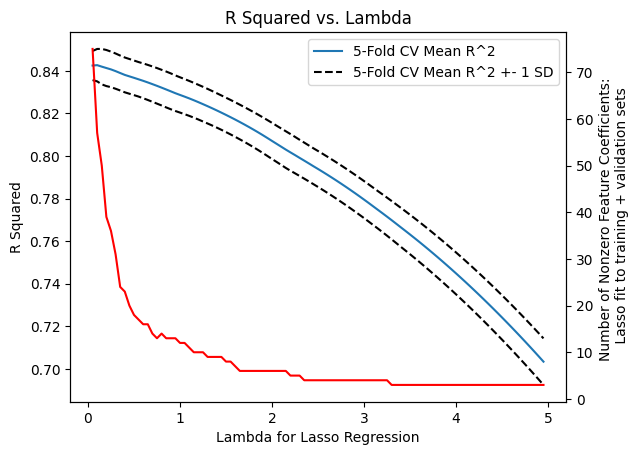

In [500]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

#Store CV means, stdevs, and number of nonzero feature coefficients
cv_means = []
cv_stds = []
nonzeros = []
#Iterate through lasso coefficients (lambda)
for lasso_coeff in np.arange(0.05, 5, 0.05):

  #Get cross-validation scores using training and validation sets, track number of nonzero feature coefficients
  multi_pred_lasso_standardized_cv = cross_val_score(Lasso(lasso_coeff), all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  #Fit lasso to training and validation sets
  multi_pred_lasso_standardized = Lasso(lasso_coeff).fit(all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  cv_means.append(multi_pred_lasso_standardized_cv.mean())
  cv_stds.append(multi_pred_lasso_standardized_cv.std())
  nonzeros.append((abs(multi_pred_lasso_standardized.coef_) > 0).sum())

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

#Plot cross-validation R^2 mean and standard deviation and number of nonzero feature coefficients
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(0.05, 5, 0.05), cv_means, label = '5-Fold CV Mean R^2')
ax.plot(np.arange(0.05, 5, 0.05), cv_means + cv_stds, '--k', label = "5-Fold CV Mean R^2 +- 1 SD")
ax.plot(np.arange(0.05, 5, 0.05), cv_means - cv_stds, '--k')
ax2 = ax.twinx()
ax2.plot(np.arange(0.05, 5, 0.05), nonzeros, 'r', label = 'Nonzero Features')
ax2.set_ylabel("Number of Nonzero Feature Coefficients: \n Lasso fit to training + validation sets")

ax.set_xlabel('Lambda for Lasso Regression')
ax.set_ylabel('R Squared')
plt.title('R Squared vs. Lambda')
#plt.legend(loc = 'center right')
ax.legend()

#Get cross-validation score on train and validation sets from 5-fold CV
multi_pred_lasso_standardized_cv = cross_val_score(Lasso(1), all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))

#Fit model to training set only, get R^2 score for validation set
multi_pred_lasso_standardized_trainonly = Lasso(1).fit(all_features_array_scaled[train_indices, :], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_lasso_standardized_validscore = multi_pred_lasso_standardized_trainonly.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

#Print R^2 values
print(("Cross-validation mean R squared: " + str(multi_pred_lasso_standardized_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_lasso_standardized_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_lasso_standardized_validscore)))

Text(0.5, 1.0, 'All-Feature Lasso Regression (lambda = 1) with Standardized Data: \n Feature Coefficients')

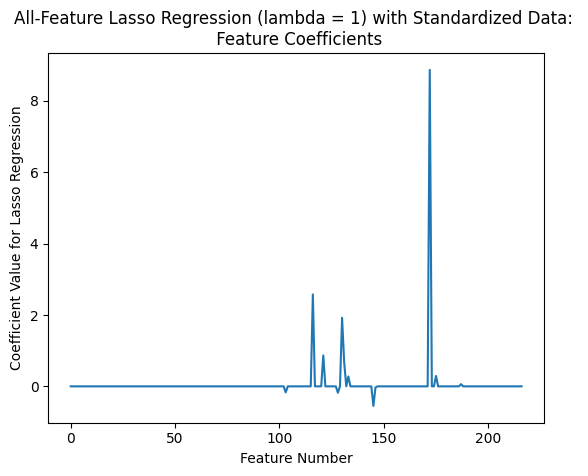

In [502]:
#Plot feature coefficients for lasso regression with lambda = 1
plt.plot(multi_pred_lasso_standardized_trainonly.coef_)
plt.xlabel('Feature Number')
plt.ylabel('Coefficient Value for Lasso Regression')
plt.title('All-Feature Lasso Regression (lambda = 1) with Standardized Data: \n Feature Coefficients')

In [519]:
multi_pred_lasso_standardized_trainonly.coef_[130]

1.9230870882105267

In [520]:
features.columns.values[130]

'wssfc1'